In [1]:
import numpy as np
from io import StringIO
import time,os, importlib
from tqdm import tqdm
np.set_printoptions(linewidth=160)
import lib.ktn_io as kio
import lib.gt_tools as gt
from scipy.sparse import save_npz,load_npz, diags, eye, csr_matrix,bmat
from scipy.sparse.linalg import eigs,inv,spsolve
from scipy.sparse.csgraph import connected_components
import scipy as sp
import scipy.linalg as spla
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import LogNorm

# Load Data

In [169]:
data_path = "KTN_data/LJ38/4k"

beta = 1.0/0.15

Nmax = None

B, K, D, N, u, s, Emin, index_sel = kio.load_mat(path=data_path,beta=beta,Emax=None,Nmax=Nmax,screen=False)
D = np.ravel(K.sum(axis=0))
BF = beta*u-s

A_states,B_states = kio.load_AB(data_path,index_sel)

basins = B_states + A_states

inter_region = ~basins

names = ["oct","ico"]

print("\n\tN_states:",N,"N_transitions:",K.data.size)
print("\n\t%d %s STATES <-> %d %s STATES" % (A_states.sum(),names[0],B_states.sum(),names[1]))
print("\n\tbeta:",beta,"\n\n")

GT_Q = gt.gt_seq(N=N,rm_reg=inter_region,B=B,D=D,trmb=50,retK=True,Ndense=50,screen=True)[2]

r_A_states = A_states[~inter_region]
r_B_states = B_states[~inter_region]
r_BF = BF[~inter_region]
print(GT_Q.shape,r_B_states.shape)

 85%|████████▍ | 650/767 [00:00<00:00, 5826.93it/s] 

N,N_TS: 4000 2653

	N_states: 900 N_transitions: 2284

	5 oct STATES <-> 128 ico STATES

	beta: 6.666666666666667 


GT regularization removing 767 states:


casting to csr_matrix
GT done, 0 rescans due to LinAlgError
(133, 133) (133,)


# Eigendecomposition of waiting times

oct -> ico : (320167.95166988514, 9829248648.8092) (320170.55319655343, 320170.55319655343)
ico -> oct : (18284.361910220985, 9759918076.631088) (18284.361910337404, 18284.361910337404)


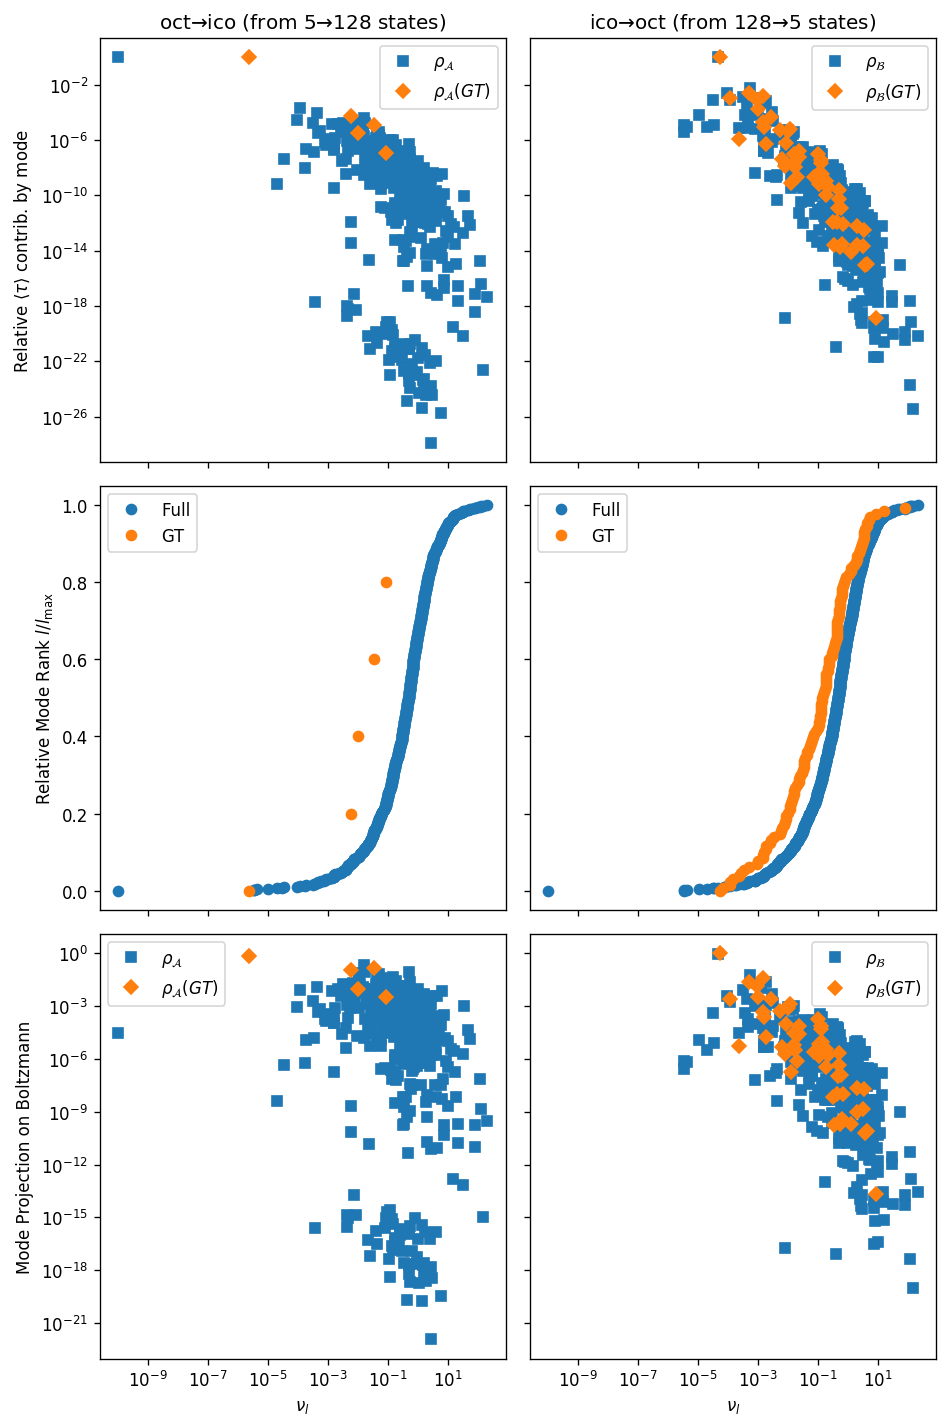

In [4]:
fig, ax = plt.subplots(3,2,figsize=(8,12),dpi=120,sharey='row',sharex='col')

Q = (diags(D)-K).todense()

rho = np.exp(-BF)
sel = [~A_states,~B_states]
r_sel = [~A_states[~inter_region],~B_states[~inter_region]]
for j in [0,1]:
    
    rho = np.exp(-BF).copy()
    
    rho[sel[j]] = 0.0 # 
    
    rho = rho[sel[1-j]] / rho[sel[1-j]].sum()
    
    
    nu,v,w = sp.linalg.eig(Q[sel[1-j],:][:,sel[1-j]],left=True,right=True)
    
    wp = np.r_[[w[:,i].real.sum()/np.sqrt(w[:,i].dot(v[:,i])) for i in nu.real.argsort()]]
    
    vp = np.r_[[v[:,i].real.dot(rho)/np.sqrt(w[:,i].dot(v[:,i])) for i in nu.real.argsort()]]
    nup = nu[nu.real.argsort()].real
    
    rho = np.exp(-BF).copy()
    rho = rho[sel[1-j]] / rho[sel[1-j]].sum()
    
    vpf = np.r_[[v[:,i].real.dot(rho)/np.sqrt(w[:,i].dot(v[:,i])) for i in nu.real.argsort()]]
    
    tau = (wp*vp/nup).sum(),(wp*vpf/nup).sum()
    
    
    ax[0,j].plot(nup,wp*vp/nup/tau[0],'s',label=r"$\rho_\mathcal{%s}$" % ['A','B'][j])
    #ax[0,j].plot(nup,wp*vpf/nup/tau[1],'o',label=r"$\rho_\mathcal{I\cup %s}$" % ['A','B'][j])
    
    ax[2,j].plot(nup,wp*vp,'s',label=r"$\rho_\mathcal{%s}$" % ['A','B'][j])
    #ax[2,j].plot(nup,wp*vpf,'o',label=r"$\rho_\mathcal{I\cup %s}$" % ['A','B'][j])
    
    #ax[1,j].plot(nup,tau[0]*np.ones(nup.size),'k--',label=r'$\langle\tau\rangle$') #np.linspace(0.,1.0,nup.size),'o')

    #ax[1,j].plot(nup,1.0/nup,'o',label='full')#np.linspace(0.,1.0,nup.size),'o')
    ax[1,j].plot(nup,np.arange(nup.size)/nup.size,'o',label='Full')
    
    r_Q = gt.gt_seq(N=N,rm_reg=inter_region,B=B,D=D,trmb=50,retK=True,Ndense=50,screen=False)[2].todense()
    
    
    
    r_rho = np.exp(-BF[~inter_region]).copy()
    r_rho[r_sel[j]] = 0.0
    r_rho = r_rho[r_sel[1-j]] / r_rho[r_sel[1-j]].sum()
    
    nu,v,w = sp.linalg.eig(r_Q[r_sel[1-j],:][:,r_sel[1-j]],left=True,right=True)
    wp = np.r_[[w[:,i].real.sum()/np.sqrt(w[:,i].dot(v[:,i])) for i in nu.real.argsort()]]
    vp = np.r_[[v[:,i].real.dot(r_rho)/np.sqrt(w[:,i].dot(v[:,i])) for i in nu.real.argsort()]]
    nup = nu[nu.real.argsort()].real
    
    r_rho = np.exp(-BF[~inter_region]).copy()
    r_rho = r_rho[r_sel[1-j]] / r_rho[r_sel[1-j]].sum()
    
    vpf = np.r_[[v[:,i].real.dot(r_rho)/np.sqrt(w[:,i].dot(v[:,i])) for i in nu.real.argsort()]]
    
    r_tau = (wp*vp/nup).sum(),(wp*vpf/nup).sum()
    
    print("%s -> %s :" % (names[j],names[1-j]),tau,r_tau)#,x.sum())
    
    ax[0,j].plot(nup,wp*vp/nup/tau[0],'D',label=r"$\rho_\mathcal{%s} (GT)$" % ['A','B'][j])
    
    #ax[1,j].plot(nup,1.0/nup,'o',label='GT') #np.linspace(0.,1.0,nup.size),'o')
    
    ax[1,j].plot(nup,np.arange(nup.size)/nup.size,'o',label='GT')
    
    ax[2,j].plot(nup,wp*vp,'D',label=r"$\rho_\mathcal{%s} (GT)$" % ['A','B'][j])
    
    ax[0,j].legend()#
    ax[1,j].legend()#
    ax[2,j].legend()#
    #ax[2,j].legend(loc="lower left")
    
    ax[0,j].set_yscale("log")
    #ax[1,j].set_yscale("log")
    ax[2,j].set_yscale("log")
    
    ax[0,j].set_xscale("log")
    ax[1,j].set_xscale("log")
    
    #ax[1,j].set_ylim(1.0e5,1.0e9)
    
    ax[0,j].set_title(r"%s$\to$%s (from %d$\to$%d states)" % (names[j],names[1-j],(~sel[j]).sum(),(~sel[1-j]).sum()))
    ax[2,j].set_xlabel(r"$\nu_l$")
    
    

ax[0,0].set_ylabel(r"Relative $\langle\tau\rangle$ contrib. by mode")#$({\rm1}\cdot{\rm w}_l)({\rm v}_l\cdot{\rho})/\nu_l/\langle\tau\rangle$")
ax[1,0].set_ylabel(r"Relative Mode Rank $l/l_{\rm max}$")#Eigenvalue $\nu_l$Relaxation Time $\nu^{-1}_l$")
ax[2,0].set_ylabel(r"Mode Projection on Boltzmann")

plt.tight_layout()

# Waiting time distribution

oct -> ico : (320167.95166988514, 9829248648.8092) (6471271038125135.0, 1.9877961816040872e+20)  GT/raw : 1.0000081255061748 4.285846442410314e-05
ico -> oct : (18284.361910220985, 9759918076.631088) (759613278.0564748, 1.9737066267334286e+20)  GT/raw : 1.0000000000063671 0.9369028363422358


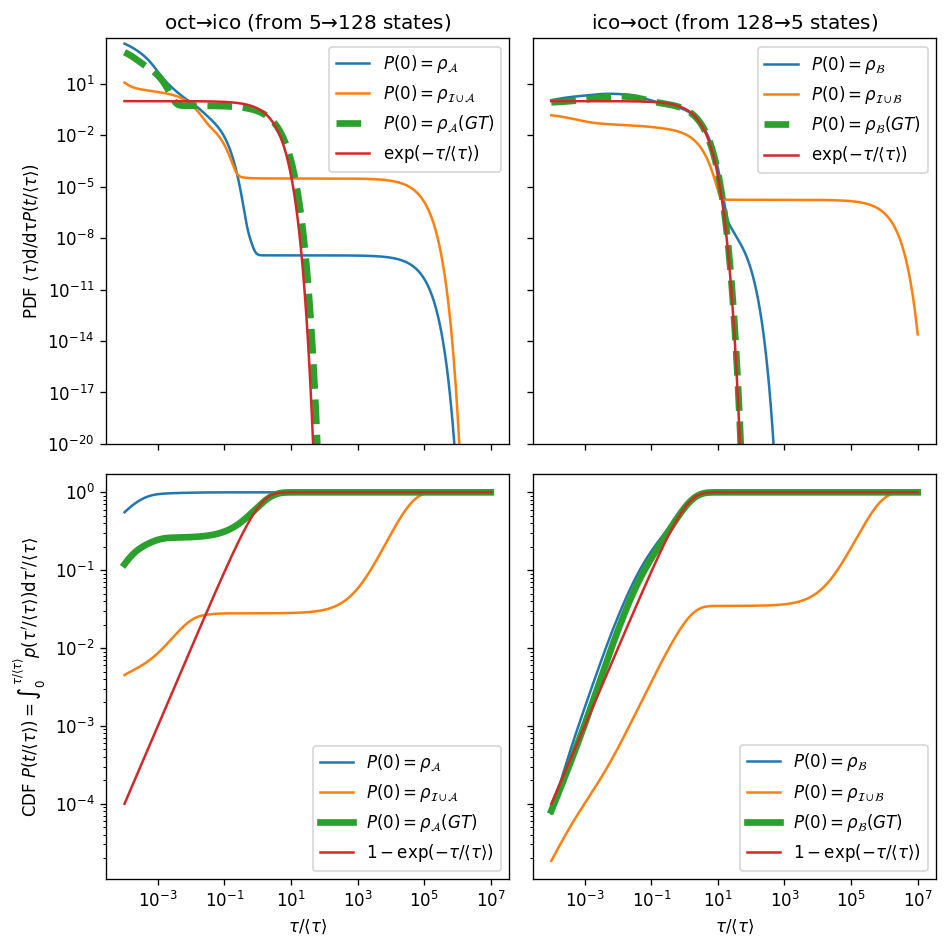

In [21]:
fig, ax = plt.subplots(2,2,figsize=(8,8),dpi=120,sharex='col',sharey='row')

Q = (diags(D)-K).todense()

rho = np.exp(-BF)
sel = [~A_states,~B_states]

ymax=1.0 # (exp)
r_sel = [~A_states[~inter_region],~B_states[~inter_region]]
for j in [0,1]:
    
    rho_I = np.exp(-BF)[sel[1-j]] / np.exp(-BF)[sel[1-j]].sum()
    rho = (rho_I * ~sel[j][sel[1-j]]) / (rho_I * ~sel[j][sel[1-j]]).sum()
        
    nu,v,w = sp.linalg.eig(Q[sel[1-j],:][:,sel[1-j]],left=True,right=True)
    
    vp = np.r_[[v[:,i].real.dot(rho)/np.sqrt(w[:,i].dot(v[:,i])) for i in nu.real.argsort()]]
    wp = np.r_[[w[:,i].real.sum()/np.sqrt(w[:,i].dot(v[:,i])) for i in nu.real.argsort()]]
    vpf = np.r_[[v[:,i].real.dot(rho_I)/np.sqrt(w[:,i].dot(v[:,i])) for i in nu.real.argsort()]]
    nup = nu[nu.real.argsort()].real
    
    tau = (wp*vp/nup).sum(),(wp*vpf/nup).sum()
    tausq = 2.0*(wp*vp/nup**2).sum(),2.0*(wp*vpf/nup**2).sum()
    
    ta = np.logspace(-4,7,1000)*tau[0]
    
    
    # PDF
    y = np.exp(-np.outer(ta,nup)).dot(wp*vp*nup)*tau[0]
    ax[0,j].plot(ta/tau[0],y,'-',label=r"$P(0)=\rho_\mathcal{%s}$" % ['A','B'][j])
    ymax = max(ymax,y.max())
    
    # PDF from +=I
    y = np.exp(-np.outer(ta,nup)).dot(wp*vpf*nup)*tau[0]
    ax[0,j].plot(ta/tau[0],y,'-',label=r"$P(0)=\rho_\mathcal{I\cup %s}$" % ['A','B'][j])
    ymax = max(ymax,y.max())
    
    
    ax[1,j].plot(ta/tau[0],1.0-np.exp(-np.outer(ta,nup)).dot(wp*vp),'-',label=r"$P(0)=\rho_\mathcal{%s}$" % ['A','B'][j])
    ax[1,j].plot(ta/tau[0],1.0-np.exp(-np.outer(ta,nup)).dot(wp*vpf),'-',label=r"$P(0)=\rho_\mathcal{I\cup %s}$" % ['A','B'][j])
    
    
    r_Q = gt.gt_seq(N=N,rm_reg=inter_region,B=B,D=D,trmb=50,retK=True,Ndense=50,screen=False)[2].todense()
    
    r_rho_I = np.exp(-BF[~inter_region])[r_sel[1-j]] / np.exp(-BF[~inter_region])[r_sel[1-j]].sum()
    r_rho = (r_rho_I * ~r_sel[j][r_sel[1-j]]) / (r_rho_I * ~r_sel[j][r_sel[1-j]]).sum()
    
    
    nu,v,w = sp.linalg.eig(r_Q[r_sel[1-j],:][:,r_sel[1-j]],left=True,right=True)
    wp = np.r_[[w[:,i].real.sum()/np.sqrt(w[:,i].dot(v[:,i])) for i in nu.real.argsort()]]
    vp = np.r_[[v[:,i].real.dot(r_rho)/np.sqrt(w[:,i].dot(v[:,i])) for i in nu.real.argsort()]]
    vpf = np.r_[[v[:,i].real.dot(r_rho_I)/np.sqrt(w[:,i].dot(v[:,i])) for i in nu.real.argsort()]]
    nup = nu[nu.real.argsort()].real
    
    r_tau = (wp*vp/nup).sum(),(wp*vpf/nup).sum()
    r_tausq = 2.0*(wp*vp/nup**2).sum(),2.0*(wp*vpf/nup**2).sum()
    
    print("%s -> %s :" % (names[j],names[1-j]),tau,tausq," GT/raw :",r_tau[0]/tau[0],r_tausq[0]/tausq[0])#,x.sum())
    
    # PDF from GT
    y = np.exp(-np.outer(ta,nup)).dot(wp*vp*nup)*tau[0]
    ax[0,j].plot(ta/tau[0],y,'--',label=r"$P(0)=\rho_\mathcal{%s} (GT)$" % ['A','B'][j],lw=4)
    ymax = max(ymax,y.max())
        
    ax[1,j].plot(ta/tau[0],1.0-np.exp(-np.outer(ta,nup)).dot(wp*vp),'-',label=r"$P(0)=\rho_\mathcal{%s} (GT)$" % ['A','B'][j],lw=4)
    
    # Single exp.
    ax[0,j].plot(ta/tau[0],np.exp(-ta/r_tau[0]),'-',label=r"$\exp(-\tau/\langle\tau\rangle)$")
    #ax[0,j].plot(ta/tau[0],np.exp(-ta/tau[1]),'-',label=r"$\exp(-\tau/\langle\tau\rangle_{\cup\mathcal{I}})$")
    
    
    ax[1,j].plot(ta/tau[0],1.0-np.exp(-ta/r_tau[0]),'-',label=r"$1-\exp(-\tau/\langle\tau\rangle)$")
    
    
    ax[0,j].legend()#ncol=2)#loc="lower center")
    ax[1,j].legend()#ncol=2)#loc="lower center")
    ax[0,j].set_yscale("log")
    ax[0,j].set_xscale("log")
    ax[1,j].set_yscale("log")
    ax[1,j].set_xscale("log")
    ax[0,j].set_title(r"%s$\to$%s (from %d$\to$%d states)" % (names[j],names[1-j],(~sel[j]).sum(),(~sel[1-j]).sum()))
    ax[0,j].set_ylim(ymin=1.0e-20,ymax=2.0*ymax)#,1.0e2)
    

ax[0,0].set_ylabel(r"PDF $\langle\tau\rangle{\rm d}/{\rm d\tau}P(t/\langle\tau\rangle)$")
ax[1,0].set_xlabel(r"$\tau/\langle\tau\rangle$")
ax[1,1].set_xlabel(r"$\tau/\langle\tau\rangle$")
ax[1,0].set_ylabel(r"CDF $P(t/\langle\tau\rangle) = \int_0^{\tau/\langle\tau\rangle} p(\tau'/\langle\tau\rangle) {\rm d}\tau'/\langle\tau\rangle$")

plt.tight_layout()

# ``cg_thresh`` has two modes : `prescan=True` just computes the max/min of rates in the largest partition. We then select this based on condition number. Else we perform the full diag

- Recursive clustering

- define max size

- Local Kemeny constant for basin


In [86]:
g = np.r_[[4,5,6,2,1]]
rr = g.argsort()[::-1]
print(g[rr])

[6 5 4 2 1]


In [170]:
def cg_thresh(_Q,_rho,_thresh,propth=0.99,prescan=False,rgf=False):
    print("HERE",rgf)
    myQ = _Q.copy()
    myrho = _rho.copy()
    lQ = myQ.minimum(myQ.transpose()).copy()
    
    lQ.data[lQ.data>0.0]=0.0
    lQ.eliminate_zeros()
    lQ.data = -np.log(-lQ.data)
    lQ.data[lQ.data>_thresh] = 0.0
    lQ.eliminate_zeros()
    nc,cc = connected_components(lQ)
    counts = np.bincount(cc)
    
    bc = cc == counts.argsort()[-1] # largest cluster
    
    if prescan:
        qd = -myQ[bc,:][:,bc].data
        return bc.sum()
    
    if rgf:
        v = (myrho[bc]).reshape((-1,1)) / np.sqrt(myrho[bc].sum())
        w = np.ones(bc.sum()).reshape((-1,1)) / np.sqrt(myrho[bc].sum())
        nu = np.r_[[(myQ[bc,:][:,bc]@v.flatten()).sum()]]
        print("RGF",nu.min(),nu.max())
        return nu,v,w,bc
    
    brho = myrho[bc] / myrho[bc].sum()
    
    nu,v,w = spla.eig(myQ[bc,:][:,bc].todense(),left=True)
    
    dp = np.sqrt(np.diagonal(w.T.dot(v))).real
    v = (v.real.dot(np.diag(1.0/dp)))
    w = (w.real.dot(np.diag(1.0/dp)))
    nu = nu.real
    
    
    retain = set([])
    for m in range(-1,2):
        lv = (w.sum(axis=0) * np.exp(-m*np.log(nu.copy())) * v.T.dot(brho))
        print(m,"target:",lv.sum(),end=" -> ")
        ranking = np.abs(lv).argsort()[::-1] # nu.argsort()
        nrt = set(ranking[:(np.abs(lv)[ranking].cumsum()>propth*np.abs(lv).sum()).argmax()+1])
        retain |= nrt# or e.g.  gaps = nu[1:] / nu[:-1] ......
        print(lv[np.r_[list(retain)]].sum(),len(retain),lv.size)
    retain  = np.r_[list(retain)]    
    
    print("NRGF",nu[retain].min(),nu[retain].max())
    return nu[retain],v[:,retain],w[:,retain], bc




def find_thresh_and_split(_Q,_rho,lsum,thra=None,propth=0.99,rgf=False):
    
    """
    if thra is None:
        qd = (diags(_Q.diagonal())-_Q).data
        qd = -np.log(qd[qd>0.0])
        th = np.linspace(3.0,np.percentile(qd,80)
        thra = np.linspace(3.0,np.percentile(qd,80),41)
        print(thra.max())
        
    for j,th in enumerate(thra[::-1]):
        cond = cg_thresh(_Q,_rho,th,propth,prescan=False)
        print(cond[0],cond[-1].sum(),cond[1].size)
        
    
    th = thra[ind]
    print("using th=",th,"min/max rate:",cond)        
    cond = cg_thresh(_Q,_rho,th,propth,prescan=True)
    """
    
    qd = -1.0*(_Q.minimum(_Q.transpose())).data
    
    qd = -np.log(qd[qd>0.0])
    th = np.percentile(qd,60)
    
    nu, v, w, bc = cg_thresh(_Q,_rho,th,propth,prescan=False,rgf=rgf)
    
    print("Removing %d-%d=%d states" %(bc.sum(),nu.size,bc.sum()-nu.size))
    
    
    S = csr_matrix(v.T)
    T = csr_matrix(w)
    
    
    
    nQ = bmat([[S@_Q[bc,:][:,bc]@T,S@_Q[bc,:][:,~bc]],[_Q[~bc,:][:,bc]@T,_Q[~bc,:][:,~bc]]])
    
    
    
    rrho = np.zeros(nQ.shape[0])
    rrho[:nu.size] = S@_rho[bc]
    rrho[nu.size:] = _rho[~bc]
    
    sumw = np.ones(nQ.shape[0])
    sumw[:nu.size] = w.T.dot(lsum[bc])
    sumw[nu.size:] = lsum[~bc]
    
    rnu,rv,rw = spla.eig(nQ.todense(),left=True)
    rdp = np.sqrt(np.diagonal(rw.T.dot(rv))).real
    rv = (rv.real.dot(np.diag(1.0/rdp))).T.dot(rrho)
    rw = (rw.real.dot(np.diag(1.0/rdp))).T.dot(sumw)
    rnu = rnu.real
    
    rtau = ((rv*rw)[rnu>0.0]/rnu[rnu>0.0]).sum()
    print(rtau,(rnu>0.0).sum())
    rta = np.logspace(-3,3,100)*rtau
    p_r = (rv*rw)[rnu>0.0]@np.exp(-np.outer(rnu[rnu>0.0],rta))
    
    return rta,p_r,rtau, sumw, rrho, nQ, rnu.max()/rnu.min()
    
    

tau: 29649191.4912702
GT_tau: 29649191.504412405
HERE False
-1 target: 1.917355486202463e-05 -> 1.7280863739811178e-05 2 430
0 target: 1.000000000000029 -> 0.7181677419128271 2 430
1 target: 151681.77666764907 -> 151428.895913733 4 430
NRGF 1.435122931497093e-07 0.0013719137552430558
Removing 430-4=426 states
4245721.606764025 469
HERE False
-1 target: 1.917355486202463e-05 -> 1.9186073689489798e-05 17 430
0 target: 1.000000000000029 -> 0.9997495347833169 18 430
1 target: 151681.77666764907 -> 151429.28698895354 18 430
NRGF 1.435122931497093e-07 1.1112203499369115
Removing 430-18=412 states
15260009.498252943 483
HERE True
RGF 1.9010983627539482e-05 1.9010983627539482e-05
Removing 430-1=429 states
417824.44640673266 465
tau: 3142187.8579967963
GT_tau: 3142187.857996805
HERE False
-1 target: 2.137215562649492e-07 -> 1.3079919858753899e-07 5 224
0 target: 1.0000000000000002 -> 1.0000587911270578 5 224
1 target: 1811700.6778607876 -> 1811709.938264203 5 224
NRGF 5.519990928827219e-07 0.19

/home/tomswinburne/miniconda2/lib/python3.7/site-packages/ipykernel_launcher.py:110: RuntimeWarning: overflow encountered in exp


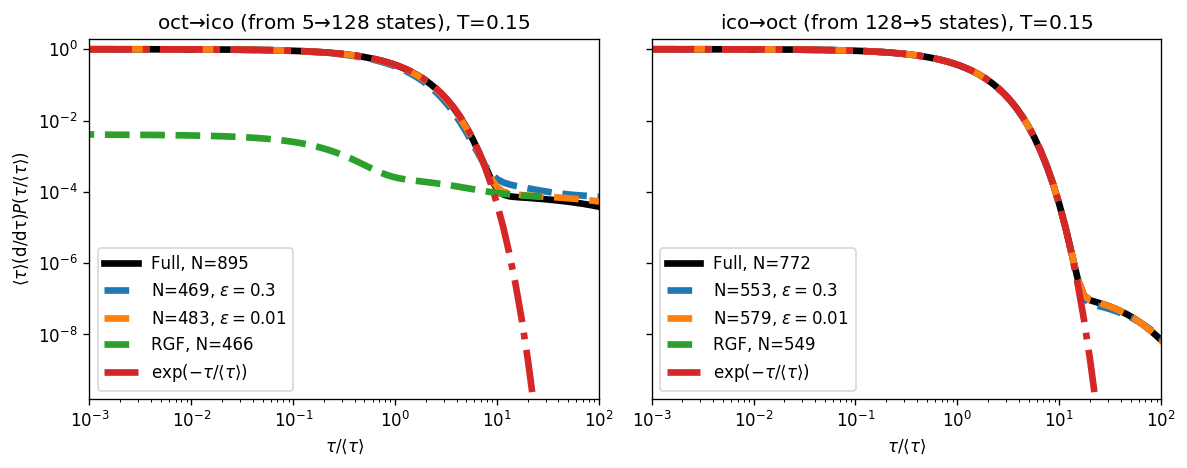

In [171]:


fig,axs = plt.subplots(1,2,figsize=(10,4),dpi=120,sharey=True)



for k in range(2):
    ax = axs[k]
    
    sel = [~A_states,~B_states]
    ax.set_title(r"%s$\to$%s (from %d$\to$%d states), T=%2.4g" % (names[k],names[1-k],(~sel[k]).sum(),(~sel[1-k]).sum(),1.0/beta))
    
    sel = [~A_states,~B_states][k]
    
    r_sel = [~r_A_states,~r_B_states][k]

    ico_D = diags(D[sel])
    ico_K = K[sel,:][:,sel].copy()
    ico_K.eliminate_zeros()

    rho = np.exp(-BF) * [B_states,A_states][k]
    rho = rho[sel] / rho[sel].sum()

    r_rho = np.exp(-r_BF) * [r_B_states,r_A_states][k]
    r_rho = r_rho[r_sel] / r_rho[r_sel].sum()

    print("tau:",spsolve(ico_D-ico_K,rho).sum())

    gt_tau = spsolve(csr_matrix(GT_Q[r_sel,:][:,r_sel]),r_rho).sum()
    print("GT_tau:",gt_tau)


    nu,v,w = spla.eig((ico_D-ico_K).todense(),left=True)
    dp = np.sqrt(np.diagonal(w.T.dot(v))).real
    v = (v.real.dot(np.diag(1.0/dp))).T.dot(rho)
    w = (w.real.dot(np.diag(1.0/dp))).sum(axis=0)
    nu = nu.real
    tau = (v*w/nu).sum()
    cond = nu.max()/nu.min()
    ta = np.logspace(-3,3,100)*tau
    p_raw = (v*w)@np.exp(-np.outer(nu,ta))

    ax.plot(ta/tau,p_raw,'k-',label=r"Full, N=%d" % (nu.size),lw=4)

    for qq in [0.3,0.01]:
        rta,r_p_r,rtau, sumw, rrho, rQ, rcond = find_thresh_and_split(ico_D-ico_K,rho,np.ones(ico_D.shape[0]),propth=1.0-qq)
        ax.plot(rta/rtau,r_p_r,'--',label=r"N=%d, $\epsilon=%2.2g$" % (rQ.shape[0],qq),lw=4)
        #print(cond/rcond,rtau,rQ.shape,rnQ.shape)
    
    rtarg,r_p_rrg,rtaurg, sumwrg, rrhorg, rQrg, rcondrg = find_thresh_and_split(ico_D-ico_K,rho,np.ones(ico_D.shape[0]),propth=1.0-qq,rgf=True)
    ax.plot(rtarg/rtau,r_p_rrg,'--',label=r"RGF, N=%d" % (rQrg.shape[0]),lw=4)
    

    """
    rrta,rr_p_r,rrtau, rsumw, rrrho, rnQ, rrcond = find_thresh_and_split(rQ.tocsr(),rrho,sumw)
    print(rrtau)

    for i in range(5):
        rrta,rr_p_r,rrtau, rsumw, rrrho, rnQ, rrcond = find_thresh_and_split(rnQ.tocsr(),rrrho,rsumw)
        print(rrtau)
    """



    ax.plot(ta/tau,np.exp(-ta/tau),'-.',label = r"$\exp(-\tau/\langle\tau\rangle)$",lw=4)

    ax.set_xlabel(r"$\tau/\langle\tau\rangle$")
    if k==0:
        ax.set_ylabel(r"$\langle\tau\rangle({\rm d}/{\rm d\tau}){P}(\tau/\langle\tau\rangle)$")
    ax.set_yscale("log")
    ax.set_xscale("log")
    ax.set_ylim(min(r_p_r.min(),p_raw.min())/10.,2.0)
    ax.set_xlim(0.001,100.)

    ax.legend()

    #print("\n",res[0],res[1],res[2],res[3].size)
plt.tight_layout()
plt.savefig("spectral_regroup_T%2.2g.pdf" % (1.0/beta))

# recursive clustering

In [50]:
def split_and_connect(_T,thresh=1.0,min_block=10):
    T = _T.copy()
    T.data[T.data>thresh] = 0.0
    T.eliminate_zeros()
    nc,cc = connected_components(T)
    
    pop = np.bincount(cc)
    
    cid = np.arange(nc)[pop>=min_block]
    cid = cid[pop[pop>=min_block].argsort()[::-1]]        
    cl = np.r_[[(cc == pc) for pc in cid]]
    return cl,np.ones(T.shape[0],bool)-cl.sum(axis=0)
    

def recursive_cluster(_M,min_block=10,max_block=150,levels=40):
    levels+=levels%2
    # find data range:
    M = _M.copy()
    M.data[M.data<0.0] = 0.0
    M.eliminate_zeros()
    
    M.data = -np.log(M.data)
    nc,cc = connected_components(M)
    pop = np.bincount(cc)
    single_nodes = np.zeros(M.shape[0],bool)
    for i in np.arange(nc)[pop==1]:
        single_nodes += (cc==i)
    
    print("\n\t%d single nodes\n" % single_nodes.sum())
    
    thlv = np.percentile(M.data,np.exp(np.linspace(np.log(10),np.log(99.9),levels)))*1.4
    
    T = M.copy()
    groups = []
    for th in thlv[::-1]:
        T.data[T.data>th] = 0.0
        T.eliminate_zeros()
        nc,cc = connected_components(T)
        pop = np.bincount(cc)
        ## all groups less than max_block and more than min_block
        lg = np.r_[[cc==ii for ii in np.arange(nc)[(pop<max_block) * (pop>=min_block)]]].astype(bool)
        
        # if largest group small enough, break
        if pop.max()<max_block:
            break
        
        # else, record them with thresh
        if lg.shape[0]>0:
            groups.append([th,lg])
        
    
    print("\n\tgroup sizes > min_block at th=",th,": ",pop[pop>=min_block]," i.e. ",len(pop[pop>=min_block]),"groups\n\n")
    print("\n\tTotal states in these groups:",pop[pop>=min_block].sum(),"/",pop.sum(),"\n\n")
    disjoint = (lg.sum(axis=0).astype(bool)==0)
    print("\n\tTotal states not in these groups:",disjoint.sum(),"/",pop.sum(),"\n\n")
    
    if len(groups)>0:
        print("\n\tGroups at other thresholds:")
    
    for g in groups:
        print("\n\tth=",g[0]," # states in groups disjoint to final thresh: ",g[1].sum(axis=1)[g[1].sum(axis=1)==(g[1]*disjoint).sum(axis=1)].sum())
    
    return lg,single_nodes #np.r_[[cc==i for i in np.arange(nc)[pop==1]]].sum(axis=0).astype(bool)
    
    
    

   
    
    
    
rm_reg = np.zeros(N,bool)
lg,sn = recursive_cluster(K[:,inter_region][inter_region,:],min_block=10,max_block=1000)
print("\t",lg.sum(axis=1),sn.sum(),(lg*(~sn)).sum())
rm_reg[inter_region] = lg[0].copy()
print(rm_reg.sum())

GT_Q = gt.gt_seq(N=N,rm_reg=rm_reg,B=B,D=D,trmb=50,retK=True,Ndense=50,screen=True)[2]

r_A_states = A_states[~rm_reg]
r_B_states = B_states[~rm_reg]
r_BF = BF[~rm_reg]
print(GT_Q.shape,r_B_states.shape,r_A_states.sum(),r_B_states.sum())


    


	148 single nodes


	group sizes > min_block at th= 28.222827976873784 :  [482  10]  i.e.  2 groups



	Total states in these groups: 492 / 767 



	Total states not in these groups: 275 / 767 


	 [482  10] 148 492
482
GT regularization removing 482 states:
casting to csr_matrix
GT done, 0 rescans due to LinAlgError
(418, 418) (418,) 5 128


tau: 130152.3126107608
GT_tau: 130152.31261076083
tau: 108042.06579188396
GT_tau: 108042.06579187786


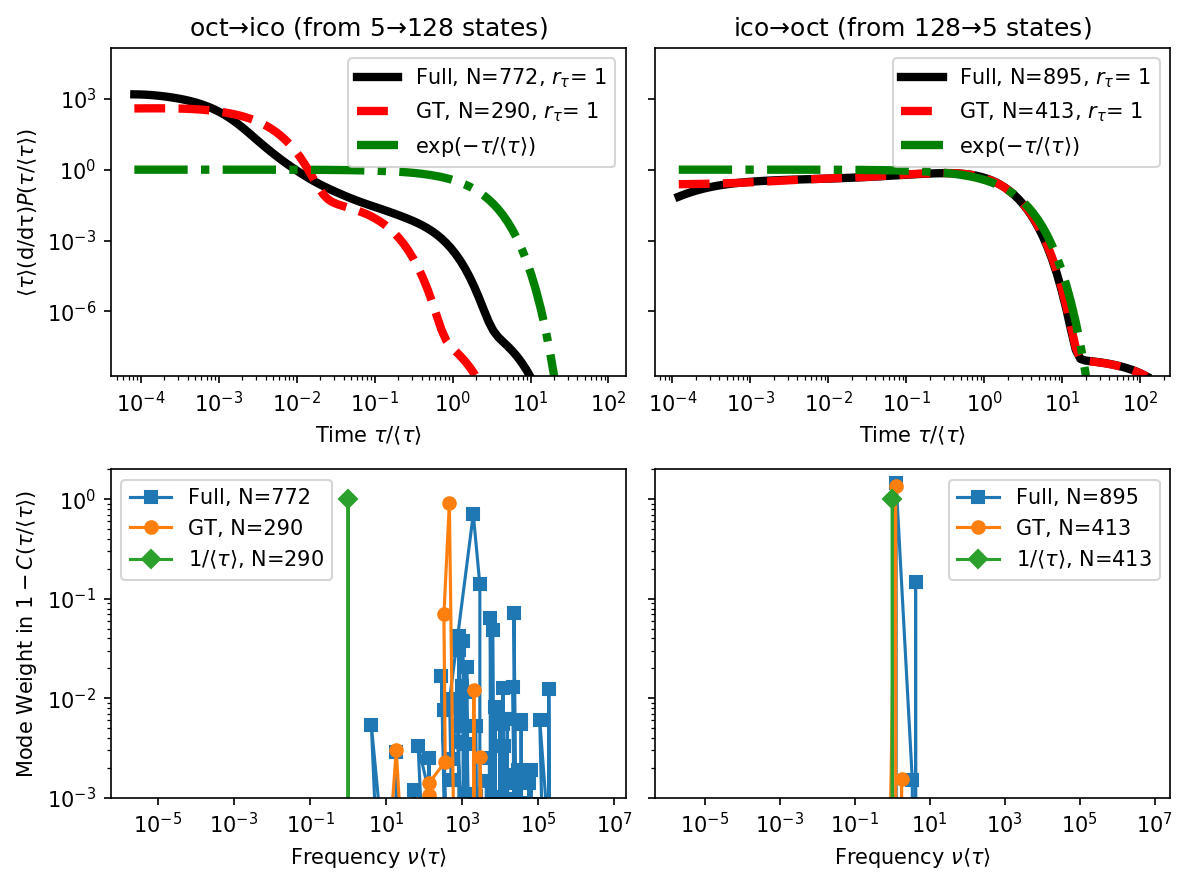

In [53]:


fig,axs = plt.subplots(2,2,figsize=(8,6),dpi=150,sharey='row')



for k in range(2):

    ax = axs[0,k]
    sax = axs[1,k]
    
    ni = [A_states.sum(),B_states.sum()]
    
    ax.set_title(r"%s$\to$%s (from %d$\to$%d states)" % (names[k],names[1-k],ni[k].sum(),ni[1-k].sum()))
    
    sel = [~B_states,~A_states][k]
    r_sel = [~r_B_states,~r_A_states][k]

    ni = [A_states,B_states][k]
    r_ni = [r_A_states,r_B_states][k]
    
    
    ico_D = diags(D[sel])
    ico_K = K[sel,:][:,sel].copy()
    ico_K.eliminate_zeros()
    
    
    rho = np.exp(-BF) * [A_states,B_states][k]
    rho = rho[sel] / rho[sel].sum()
    
    rho[rho.argmax()] =  1.0
    rho[np.arange(rho.size)!=rho.argmax()] = 0.0
    
    r_rho = np.exp(-r_BF) * [r_A_states,r_B_states][k]
    r_rho = r_rho[r_sel] / r_rho[r_sel].sum()
    r_rho[r_rho.argmax()] =  1.0
    r_rho[np.arange(r_rho.size)!=r_rho.argmax()] = 0.0
    
    
    
    
    print("tau:",spsolve(ico_D-ico_K,rho).sum())
    
    ta = np.logspace(-4,2.0,100)*tau

    gt_tau = spsolve(csr_matrix(GT_Q[r_sel,:][:,r_sel]),r_rho).sum()
    print("GT_tau:",gt_tau)


    nu,v,w = spla.eig((ico_D-ico_K).todense(),left=True)
    dp = np.sqrt(np.diagonal(w.T.dot(v))).real
    v = (v.real.dot(np.diag(1.0/dp))).T.dot(rho)
    w = (w.real.dot(np.diag(1.0/dp))).sum(axis=0)
    nu = nu.real
    tau = (v*w/nu).sum()
    cond = nu.max()/nu.min()
    
    p_raw = (v*w*nu)@np.exp(-np.outer(nu,ta))*tau
    #p_raw = 1.0-(v*w)@np.exp(-np.outer(nu,ta))
    
    
    
    ax.plot(ta/tau,p_raw,'k-',label=r"Full, N=%d, $r_\tau$=%2.2g" % (nu.size,1.0),lw=4)
    sax.plot(nu*tau,(v*w),'s-',label=r"Full, N=%d" % nu.size)
    

    
    nu,v,w = spla.eig(GT_Q[r_sel,:][:,r_sel].todense(),left=True)
    dp = np.sqrt(np.diagonal(w.T.dot(v))).real
    v = (v.real.dot(np.diag(1.0/dp))).T.dot(r_rho)
    w = (w.real.dot(np.diag(1.0/dp))).sum(axis=0)
    nu = nu.real
    tau = (v*w/nu).sum()
    rcond = nu.max()/nu.min()
    
    #r_p_raw = 1.0-(v*w)@np.exp(-np.outer(nu,ta))
    r_p_raw = (v*w*nu)@np.exp(-np.outer(nu,ta))*tau

    ax.plot(ta/tau,r_p_raw,'r--',label=r"GT, N=%d, $r_\tau$=%2.2g" % (nu.size,1.0),lw=4)
    sax.plot(nu*tau,(v*w),'o-',label=r"GT, N=%d" % nu.size)
    
    #ax.plot(ta/tau,1-np.exp(-ta/tau),'g-.',label=r"$\exp(-\tau/\langle\tau\rangle)$",lw=4)
    ax.plot(ta/tau,np.exp(-ta/tau),'g-.',label=r"$\exp(-\tau/\langle\tau\rangle)$",lw=4)
    sax.plot(np.r_[[0.99,1.0,1.01]],np.r_[[1.0e-9,1.0,1.0e-9]],'D-',label=r"$1/\langle\tau\rangle$, N=%d" % nu.size)

    
    
    ax.set_xlabel(r"Time $\tau/\langle\tau\rangle$")
    sax.set_xlabel(r"Frequency $\nu\langle\tau\rangle$")
    if k==0:
        ax.set_ylabel(r"$\langle\tau\rangle({\rm d}/{\rm d\tau}){P}(\tau/\langle\tau\rangle)$")
        #ax.set_ylabel(r"${C}(\tau/\langle\tau\rangle)$")
        sax.set_ylabel(r"Mode Weight in $1-{C}(\tau/\langle\tau\rangle)$")

    ax.set_yscale("log")
    ax.set_xscale("log")
    ax.set_ylim(ymin=p_raw.min())#0.01,1.1)
    ax.legend()

    sax.set_yscale("log")
    sax.set_xscale("log")
    sax.set_ylim(0.001,2.0)
    sax.legend()

plt.tight_layout()
    